# Customer Churn Prediction - Deep Metric Evaluation

**Metrics Evaluated**:
- **ROC-AUC**: Discriminative power.
- **Recall**: Ability to catch churners (Critical).
- **Precision**: Correctness of churn predictions.
- **F1-Score**: Balance between Precision and Recall.
- **Accuracy**: Overall correctness.

**Methodology**:
1. **Benchmark**: Train 10+ models and record ALL metrics using 5-Fold Stratified CV.
2. **Comparison**: Visualize metrics side-by-side to understand trade-offs.
3. **Select & Tune**: Pick top performers based on AUC/Recall and tune them.
4. **Stacking**: Ensemble the tuned models.
5. **Final Showdown**: Detailed classification reports for the finalists.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score, recall_score, precision_score
)

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# Load Data
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

## 1. Multi-Metric Benchmark

In [3]:
models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, class_weight='balanced', random_state=42),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GBM": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', scale_pos_weight=3, random_state=42),
    "LightGBM": LGBMClassifier(verbose=-1, class_weight='balanced', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, auto_class_weights='Balanced', random_state=42)
}

results = []
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

print("Benchmarking models across 5 metrics")

for name, model in models.items():
    start = time.time()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Multi-metric Cross Validation
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring_metrics)
    
    model.fit(X_train, y_train)
    took = time.time() - start
    
    results.append({
        'Model': name,
        'Accuracy': cv_results['test_accuracy'].mean(),
        'Precision': cv_results['test_precision'].mean(),
        'Recall': cv_results['test_recall'].mean(),
        'F1-Score': cv_results['test_f1'].mean(),
        'ROC-AUC': cv_results['test_roc_auc'].mean(),
        'Time': took,
        'Estimator': model
    })

benchmark_df = pd.DataFrame(results).sort_values(by='ROC-AUC', ascending=False)
benchmark_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Time']]

Benchmarking models across 5 metrics


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Time
5,AdaBoost,0.800321,0.652340,0.534448,0.586725,0.847507,2.332457
6,GBM,0.803517,0.661859,0.531104,0.589125,0.846894,7.424893
0,LogReg,0.748139,0.516626,0.794649,0.625972,0.846388,0.263757
9,CatBoost,0.768728,0.546781,0.751839,0.633028,0.843189,20.979792
8,LightGBM,0.770681,0.551035,0.733779,0.629247,0.836538,0.569974
4,RandomForest,0.792510,0.651375,0.470903,0.546338,0.826710,4.131482
2,SVM,0.752043,0.521845,0.780602,0.625312,0.826578,21.771384
7,XGBoost,0.768550,0.554124,0.654849,0.600182,0.823243,2.757491
1,KNN,0.763758,0.559336,0.518395,0.537965,0.780063,2.165793
3,DecisionTree,0.739441,0.510269,0.500334,0.504756,0.663212,0.299309


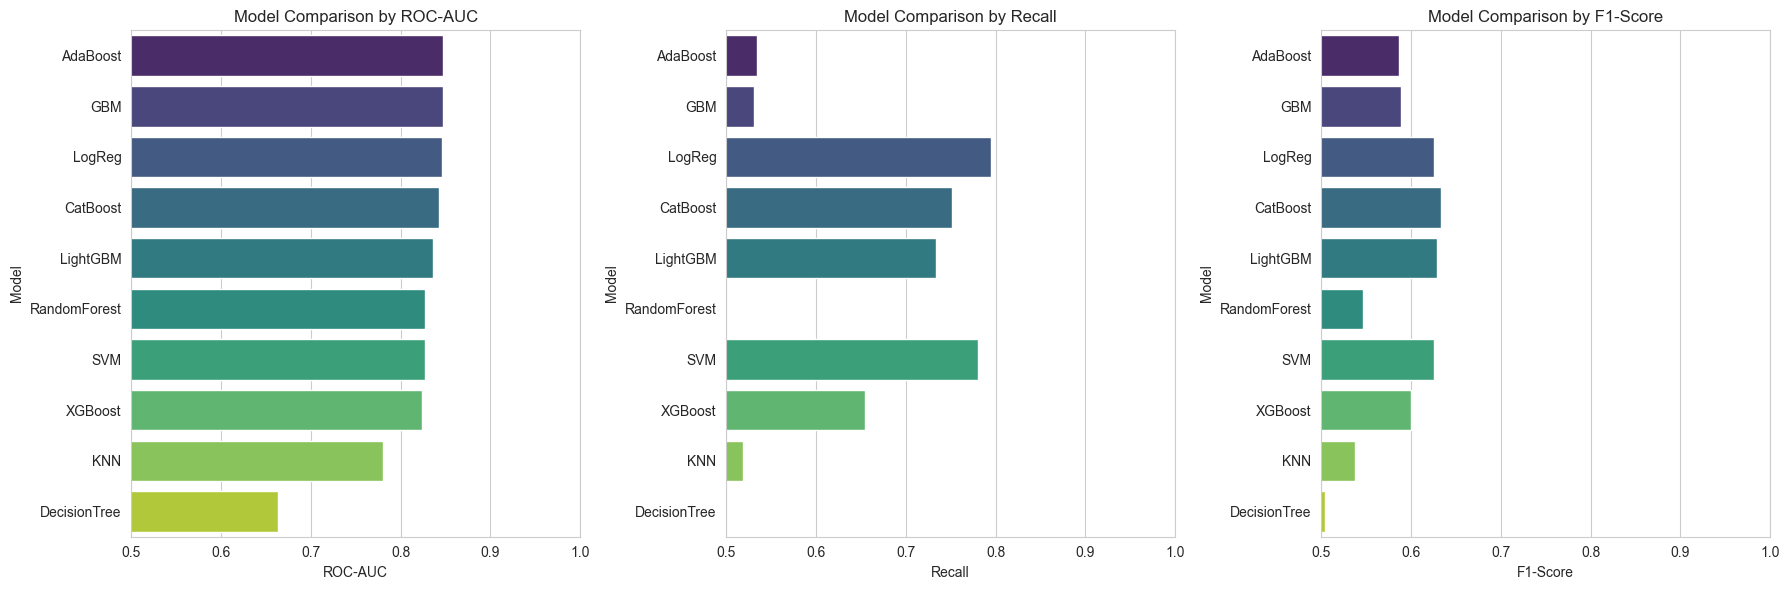

In [4]:
# Visualize Metrics
metrics_to_plot = ['ROC-AUC', 'Recall', 'F1-Score']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(x=metric, y='Model', data=benchmark_df, hue='Model', legend=False, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Model Comparison by {metric}')
    axes[i].set_xlim(0.5, 1.0)

plt.tight_layout()
plt.show()

## 2. Tune Top 3 Models

In [5]:
top_3_names = benchmark_df.head(3)['Model'].tolist()
print(f"Selection based on ROC-AUC: {top_3_names}")

# Define Parameter Grids (Same as before)
param_grids = {
    "XGBoost": {'n_estimators': [100, 300], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5], 'colsample_bytree': [0.7, 1.0]},
    "LightGBM": {'n_estimators': [100, 300], 'learning_rate': [0.01, 0.1], 'num_leaves': [31, 50]},
    "CatBoost": {'iterations': [300, 500], 'learning_rate': [0.01, 0.1], 'depth': [4, 6]},
    "RandomForest": {'n_estimators': [200, 400], 'max_depth': [10, 20], 'min_samples_split': [2, 10]},
    "SVM": {'C': [1, 10], 'gamma': ['scale', 0.1]},
    "GBM": {'n_estimators': [100, 300], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
    "AdaBoost": {'n_estimators': [50, 100], 'learning_rate': [0.1, 1.0]},
    "LogReg": {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
}

tuned_models = {}

for name in top_3_names:
    print(f"Tuning {name}...")
    base = models[name]
    grid = param_grids.get(name, {})
    
    if grid:
        search = RandomizedSearchCV(base, grid, n_iter=10, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1, verbose=0)
        search.fit(X_train, y_train)
        tuned_models[name] = search.best_estimator_
        print(f"  Best AUC: {search.best_score_:.4f}")
    else:
        tuned_models[name] = base
        print(f"  No grid, using base.")

Selection based on ROC-AUC: ['AdaBoost', 'GBM', 'LogReg']
Tuning AdaBoost...


d:\Study\Coding\Project\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


  Best AUC: 0.8468
Tuning GBM...


d:\Study\Coding\Project\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


  Best AUC: 0.8479
Tuning LogReg...


d:\Study\Coding\Project\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


  Best AUC: 0.8467


## 3. Stacking Ensemble

In [6]:
estimators = [(name, model) for name, model in tuned_models.items()]
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

print("Training Stacking Ensemble with Tuned Models...")
stack.fit(X_train, y_train)
tuned_models['Stacking'] = stack

Training Stacking Ensemble with Tuned Models...


## 4. Final Showdown (All Metrics)

In [7]:
final_results = []

print("Evaluating Finalists on Test Data:")

for name, model in tuned_models.items():
    # Predict Probabilities and Classes
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate all metrics
    res = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob),
        'Estimator': model
    }
    final_results.append(res)

final_df = pd.DataFrame(final_results).sort_values(by='ROC-AUC', ascending=False)
final_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]

Evaluating Finalists on Test Data:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
3,Stacking,0.799858,0.651316,0.529412,0.584071,0.845617
1,GBM,0.805536,0.676056,0.513369,0.583587,0.843145
0,AdaBoost,0.801278,0.649682,0.545455,0.593023,0.843093
2,LogReg,0.734564,0.500000,0.786096,0.611227,0.841238


In [8]:
# Select Winner
Best_Model = final_df.iloc[0]['Model']
winner_model = final_df.iloc[0]['Estimator']
print(f" Best Model: {Best_Model}")

# Save
joblib.dump(winner_model, '../models/churn_model_xgb.pkl')
print("Winner saved to models/churn_model_xgb.pkl")

 Best Model: Stacking
Winner saved to models/churn_model_xgb.pkl
